In [1]:
# prompt: above are directories

import os
import shutil

# Assuming you have a folder named 'xray_data' with subfolders 'no_osteoporosis' and 'osteoporosis'.
# You can adjust the paths accordingly.


# Paths to your data folders
normal_dir = 'C:/Users/ADMIN/Downloads/archive (4)/normal/normal'
osteo_dir = 'C:/Users/ADMIN/Downloads/archive (4)/osteoporosis/osteoporosis'

# Check if the directories exist
if not os.path.exists(normal_dir):
    print(f"Error: Directory '{normal_dir}' does not exist.")
if not os.path.exists(osteo_dir):
    print(f"Error: Directory '{osteo_dir}' does not exist.")

# List the files in each directory (optional)
normal_files = os.listdir(normal_dir)
osteo_files = os.listdir(osteo_dir)
print(f"Number of normal X-ray images: {len(normal_files)}")
print(f"Number of osteoporosis X-ray images: {len(osteo_files)}")



Number of normal X-ray images: 186
Number of osteoporosis X-ray images: 186


In [2]:
# prompt: Standardize the size of X-ray images for consistent input to your machine learning model (e.g., 224x224 pixels).Scale pixel values to a range (e.g., between 0 and 1). gray scale is true

from PIL import Image
import numpy as np

def standardize_images(image_dir, target_size=(224, 224)):
  """
  Standardizes the size and pixel values of X-ray images in a directory.

  Args:
    image_dir: Path to the directory containing the images.
    target_size: Desired size of the images (width, height).

  Returns:
    A list of standardized image arrays.
  """
  standardized_images = []
  for filename in os.listdir(image_dir):
    try:
      image_path = os.path.join(image_dir, filename)
      image = Image.open(image_path).convert("L")  # Open in grayscale
      image = image.resize(target_size)
      image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]
      standardized_images.append(image_array)
    except Exception as e:
      print(f"Error processing image {filename}: {e}")

  return standardized_images


# Standardize the normal and osteoporosis images
standardized_normal_images = standardize_images(normal_dir)
standardized_osteo_images = standardize_images(osteo_dir)

print(f"Number of standardized normal images: {len(standardized_normal_images)}")
print(f"Number of standardized osteoporosis images: {len(standardized_osteo_images)}")


Number of standardized normal images: 186
Number of standardized osteoporosis images: 186


In [3]:
# prompt: Divide the dataset into training, validation, and test sets.

from sklearn.model_selection import train_test_split

# Combine the standardized images and create corresponding labels (0 for normal, 1 for osteoporosis)
images = standardized_normal_images + standardized_osteo_images
labels = [0] * len(standardized_normal_images) + [1] * len(standardized_osteo_images)

# Convert lists to NumPy arrays for easier manipulation
images = np.array(images)
labels = np.array(labels)

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 260
Validation set size: 56
Test set size: 56


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set input shape according to your image size, for example, 224x224 pixels with 1 channel (grayscale).
input_shape = (224, 224, 1)  # Grayscale X-ray images

# Define a simple CNN model
def create_basic_cnn():
    model = models.Sequential()
    
    # First convolutional layer with 32 filters and a 3x3 kernel
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Third convolutional layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten the output to feed into a Dense (fully connected) layer
    model.add(layers.Flatten())
    
    # Fully connected layer with 128 units
    model.add(layers.Dense(128, activation='relu'))
    
    # Output layer with 1 unit for binary classification (osteoporosis or not)
    model.add(layers.Dense(1, activation='sigmoid'))  # Use 'softmax' for multiclass

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multiclass
                  metrics=['accuracy'])
    
    return model

# Instantiate the model
model = create_basic_cnn()

# Display the architecture of the model
model.summary()

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5767 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6871
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6168 - loss: 0.6239 - val_accuracy: 0.7321 - val_loss: 0.5544
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7388 - loss: 0.5035 - val_accuracy: 0.7321 - val_loss: 0.5695
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7668 - loss: 0.4835 - val_accuracy: 0.7321 - val_loss: 0.5592
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7815 - loss: 0.4317 - val_accuracy: 0.7321 - val_loss: 0.5517
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8192 - loss: 0.3876 - val_accuracy: 0.6964 - val_loss: 0.5527
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8795 - loss: 0.2858 - val_accuracy: 0.6786 - val_loss: 0.5939
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8928 - loss: 0.2717 - val_accuracy: 0.7143 - val_loss: 0.6201
Epoch 9/

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc*100}%")

2/2 - 1s - 388ms/step - accuracy: 0.6964 - loss: 0.9141
Test accuracy: 69.64285969734192%


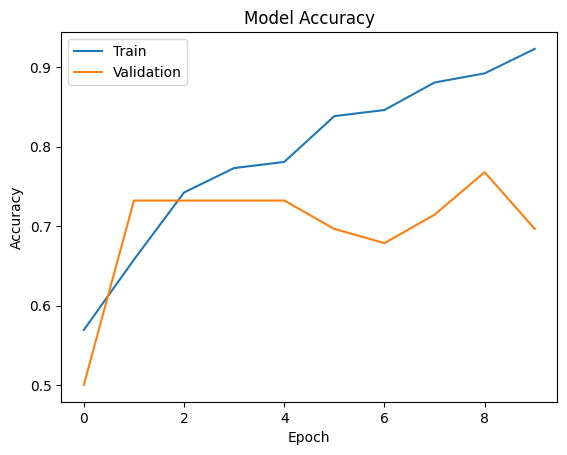

In [7]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


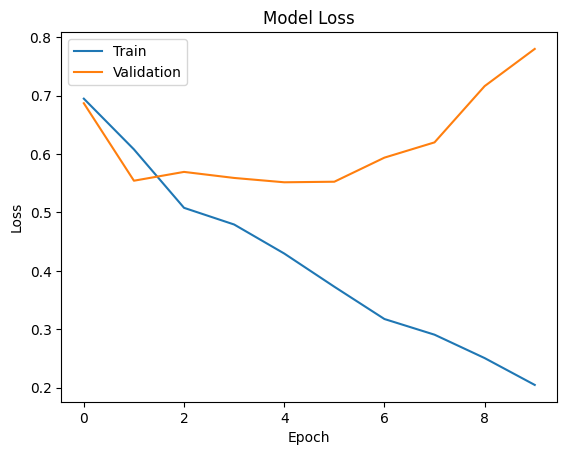

In [9]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [11]:
# prompt: take a image input then predict if it is normal or osteoporosis

from PIL import Image
import numpy as np

def predict_osteoporosis(image_path, model):
  """
  Predicts whether an X-ray image shows osteoporosis.

  Args:
    image_path: Path to the X-ray image file.
    model: The trained CNN model.

  Returns:
    A prediction (0 for normal, 1 for osteoporosis) and the probability.
  """
  try:
    image = Image.open(image_path).convert("L")
    image = image.resize((224, 224))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = np.expand_dims(image_array, axis=3)  # Add channel dimension (grayscale)
    prediction = model.predict(image_array)
    return prediction[0][0]
  except Exception as e:
    print(f"Error processing image: {e}")
    return None


# Predict a image 
input_image_path = 'C:/Users/ADMIN/Downloads/archive (4)/osteoporosis/osteoporosis/19.JPEG'  # Replace with your input image path

prediction = predict_osteoporosis(input_image_path, model)

if prediction is not None:
  if prediction < 0.5:
    print("Prediction: Normal")
  else:
    print("Prediction: Osteoporosis")
  print(f"Probability: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Prediction: Osteoporosis
Probability: 0.9888470768928528


In [14]:
model.save('your_model.keras')